# Lecture 1
---

### Defining LGM function to generate random numbers
---

In [1]:
import time
"""
Rseed is our own LGM RNG seed generator which uses time, memory address and hashing to 
generate random numbers using the LGM logic. It is pseudo random and deterministic
but you need to know all the variables (time, memory and entropy) at all the addresses 
to reverse engineer it.
"""
def Rseed(extra_entropy: int = 0) -> int:
    a = 16807
    b = 12345
    m = 2**31 - 1
    prime_multiplier = 2654435761

    # Build entropy from scratch
    t1 = int(time.time() * 1e9)              # nanosecond resolution
    t2 = int(time.perf_counter() * 1e9)      # perf counter for variation
    obj_id = id(object())                    # memory address
    raw = str(t1 + t2 + obj_id + extra_entropy * prime_multiplier)

    hashed = abs(hash(raw))                  # deterministic chaos
    seed = (a * hashed + b) % m
    return seed



import numpy as np

m = (2**31) - 1
a = 7**5

def LGM_gen(n, seed = Rseed()):
    result = []
    X = seed
    for i in range(n):
        X = (a * X) % m
        result.append(X)
    return result

### Generating Uniform Samples using the LGM function
<hr>

In [76]:
def Uniform_gen(n, seed = Rseed()):
    raw = np.array(LGM_gen(n, seed))
    return (raw/m).tolist()

In [2]:
import matplotlib.pyplot as plt
def plot_uniform(n, seed = Rseed()):
    values = Uniform_gen(n, seed)
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=5, edgecolor='black', color='#BB0A1E', density=True)
    plt.title(f"Probability Distribution of Values for N = {n:,.0f}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(False)
    plt.show()

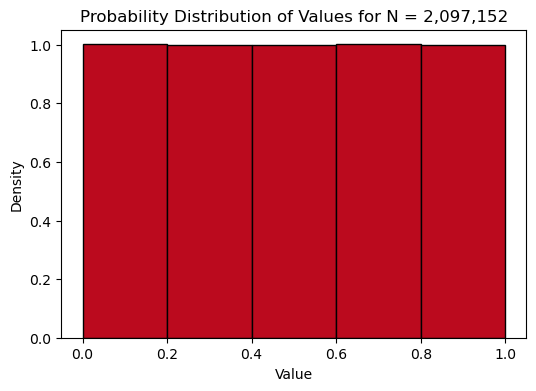

In [4]:
plot_uniform((2**21))

<hr>

### Using Recursive Property of Binomial to generate Binomial distribution ***(Not the answer to 1.a)***
<hr>

In [5]:
def binomial_gen_recursive(n, p, N, seed = Rseed(),):
    if not isinstance(p, (int, float)) or not (0 <= p <= 1):
        raise ValueError("p must be a numeric value in the interval [0, 1]")
    if not isinstance(n, int) or (n <= 0):
        raise ValueError("n must be a positive integer")
    uniforms = Uniform_gen(N, seed)
    binomials = []
    
    for Ui in uniforms:
        k = 0
        z = p/(1-p)
        y = (1-p)**n
        x = y
        while(True):
            if Ui < x:
                binomials.append(k)
                break
            else:
                y = ((n-k)/(k+1)) * z * y
                k += 1
                x += y
    return binomials
                
        

In [6]:
def plot_binomial(n, p, N, seed = Rseed()):
    values = binomial_gen_recursive(n, p, N, seed)
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=range(n + 2), edgecolor='black', color='#FF0080', density=True)
    plt.title(f"Probability Distribution of Binomial for n = {n:,.0f}, p = {p:0.2f} & samples = {N:,.0f}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(False)
    plt.show()

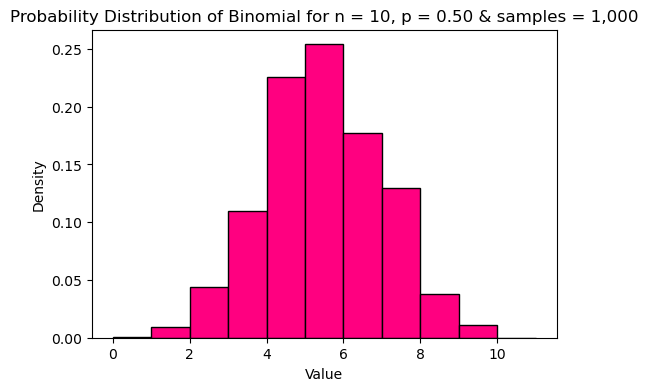

In [7]:
plot_binomial(10, 0.5, 1000)

<hr>

## **Q1)a.** Generate 1,000 random numbers with Binomial distribution (n = 44, p = 0.64) using Bernoulli Decomposition Method
<hr>

In [8]:
# Define the Bernoulli generator that leverages our Uniform generator based on LGM
def bernoulli_gen(p: float, N: int, seed: int = Rseed()) -> list:
    """
    Generate N Bernoulli(p) random variables using uniform sampling.

    Parameters:
    - p (float): Probability of success, must be in [0, 1].
    - N (int): Number of Bernoulli random variables to generate.
    - seed (int, optional): Seed for random number generator. Default is current system time.

    Returns:
    - list of int: A list of 0s and 1s representing Bernoulli outcomes.
    """
    if not isinstance(p, (int, float)) or not (0 <= p <= 1):
        raise ValueError("p must be a numeric value in the interval [0, 1]")
    if not isinstance(N, int) or (N <= 0):
        raise ValueError("n must be a positive integer")
    bernoullis = []
    uniforms = Uniform_gen(N, seed)
    for Ui in uniforms:
        if Ui < p:
            bernoullis.append(1)
        else:
            bernoullis.append(0)
    return bernoullis
  
# Generate Binomial distribution using Bernoulli decomposition
def binomial_bernoulli_decomposition(n : int, p : float, N : int, seed : int = Rseed()) -> list:
    binomials = []
    for i in range(N):
        bernoullis = bernoulli_gen(p, n, Rseed(Rseed())) 
        X = sum(bernoullis)
        binomials.append(X)
    return binomials

In [9]:
def plot_binomial2(n, p, N, seed = Rseed()):
    values = binomial_bernoulli_decomposition(n, p, N, seed)
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=range(n + 2), edgecolor='black', color='#734F96', density=True)
    plt.title(f"Probability Distribution of Binomial for n = {n:,.0f}, p = {p:0.2f} & samples = {N:,.0f}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(False)
    plt.show()

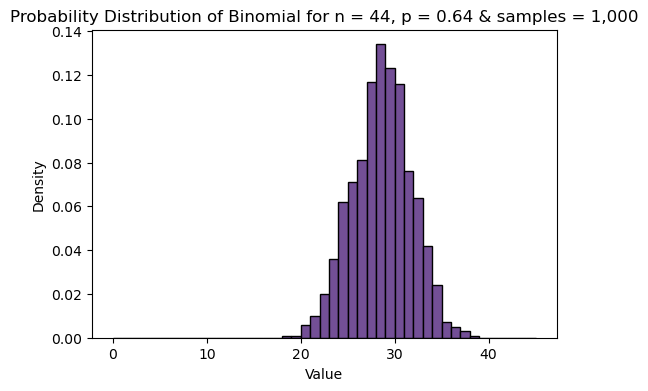

In [10]:
plot_binomial2(44, 0.64, 1000)

### Computing Probability P(X >= 35) for Binomial(n = 44, p = 0.64) using Binomial CDF and comparing it to the emperical probability using our RNG
---

In [31]:
from scipy.stats import binom
n = 44
p = 0.64
cdf_34 = binom.cdf(34, n, p)
prob = 1 - cdf_34
emperical_prob = sum(1 for x in binomial_bernoulli_decomposition(44, 0.64, 1000) if x >= 35)/1000
print(f"Emperical Probability: {emperical_prob * 100: 0.3f}%; Statistical Probability: {prob * 100: 0.3f}%")

Emperical Probability:  2.000%; Statistical Probability:  2.003%


* The Emperical Probability is close to the Statistical Probability (although its value will change every time we run the code)
* The probability will converge to its real statistical value if we increase the sample size due to Law of Large Numbers

In [32]:
# When N = 1 Million
N = 1_000_000
emperical_prob = sum(1 for x in binomial_bernoulli_decomposition(44, 0.64, N) if x >= 35)/N
print(f"Emperical Probability: {emperical_prob * 100: 0.3f}%; Statistical Probability: {prob * 100: 0.3f}%")

Emperical Probability:  1.987%; Statistical Probability:  2.003%


* Pretty close. Also less close to n = 1000, but this will be more consistent.

In [35]:
M = 1_000_000
K = 1_000
for i in range(5):
    emperical_prob_M = sum(1 for x in binomial_bernoulli_decomposition(44, 0.64, M) if x >= 35)/M
    emperical_prob_K = sum(1 for x in binomial_bernoulli_decomposition(44, 0.64, K) if x >= 35)/K
    print(f"Iteration {i+1} -> Emperical Probability x1000: {emperical_prob_K * 100: 0.3f}%; Emperical Probability x1M: {emperical_prob_M * 100: 0.3f}%; Statistical Probability: {prob * 100: 0.3f}%")

Iteration 1 -> Emperical Probability x1000:  1.800%; Emperical Probability x1M:  2.018%; Statistical Probability:  2.003%
Iteration 2 -> Emperical Probability x1000:  2.300%; Emperical Probability x1M:  2.000%; Statistical Probability:  2.003%
Iteration 3 -> Emperical Probability x1000:  0.800%; Emperical Probability x1M:  2.007%; Statistical Probability:  2.003%
Iteration 4 -> Emperical Probability x1000:  2.800%; Emperical Probability x1M:  1.994%; Statistical Probability:  2.003%
Iteration 5 -> Emperical Probability x1000:  1.700%; Emperical Probability x1M:  1.983%; Statistical Probability:  2.003%


<hr>

## **Q3)b.** 
Generate 10,000 Exponentially distributed random numbers with parameter $\lambda = 1.5$. 
Estimate $P(X \geq 1); \quad P(X \geq 4);$
and compute the empirical mean and the standard deviation of the sequence of 10,000 numbers. 
Draw the histogram by using the 10,000 numbers you have generated.


$Note:$ Random variable $X$ that is exponentially distributed with parameter $\lambda$ has the following cdf: 
$$
F(t) = P(X \leq t) = 1 - e^{-t/\lambda} \quad \text{for } t \geq 0 \quad (\text{and } \mathbb{E}(X) = \lambda.)
$$
<hr>

In [11]:
# Creating a function to generate Exponential RVs leveraging our uniform RV generator and using inverse CDF methodology

def Exponential_gen(Lambda, N, seed = Rseed()):
    uniforms = np.array(Uniform_gen(N, seed))
    X = -1*Lambda*np.log(uniforms) # We can also do (1-uniforms) but its the same thing
    return X.tolist()

def Prob_gt_k(distribution, k):
    return sum(1 for x in distribution if x >= k)/len(distribution)

In [12]:
Exponentials = Exponential_gen(1.5, 10_000, Rseed(Rseed()))
p_gt_1 = Prob_gt_k(Exponentials, 1)
p_gt_4 = Prob_gt_k(Exponentials, 4)
empirical_mean = np.mean(Exponentials)
empirical_std = np.std(Exponentials)
print(f"""
\033[1;3mP(X≥1):\033[0m {p_gt_1*100:6.3f}%
\033[1;3mP(X≥4):\033[0m {p_gt_4*100:6.3f}%
\033[1;3mEmpirical Mean:\033[0m {empirical_mean:5.2f}
\033[1;3mEmpirical STD:\033[0m {empirical_std:5.2f}
""")



P(X≥1): 50.830%
P(X≥4):  6.890%
Empirical Mean:  1.50
Empirical STD:  1.53



In [13]:
import matplotlib.pyplot as plt

def plot_exponential_hist(data, mean):
    """
    Plot histogram for an array of Exponential random variables.

    Parameters:
    - data (list or array): Array of exponentially distributed values
    - mean (float): The mean (λ) used for generation
    """
    N = len(data)
    
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50, edgecolor='black', color='#e5a644', density=True)
    plt.title(f'Histogram of {N:,} Exponential RVs (mean = {mean})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(False)
    plt.show()


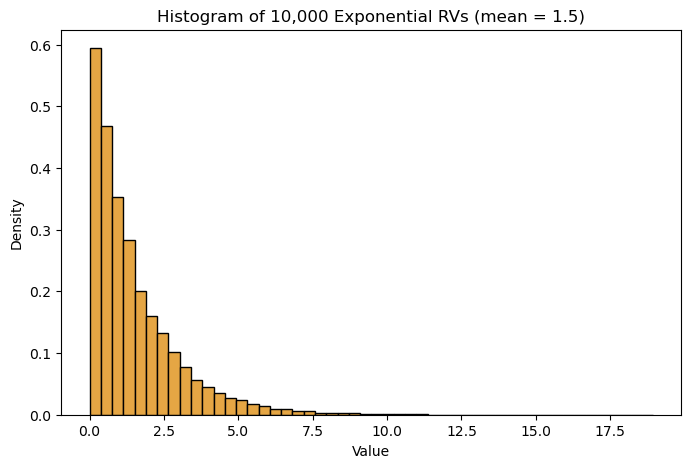

In [14]:
plot_exponential_hist(Exponentials, 1.5)

<hr>

## **Q1)c.**
Generate 5,000 Normally distributed random numbers with mean 0 and variance 1, by using the **Box-Muller Method**.
<hr>

In [3]:
"""
We don't want 0 as an output of uniform RVs, since Log(0) is unbounded.
Therefore our Uniform is (LGM output + 1/2) divided by m
Also will put a condition in our Box Muller Function
"""
def Uniform_gen_BM(n, seed = Rseed()):
    raw = np.array(LGM_gen(n, seed))
    return ((raw+0.5)/m).tolist()

def BoxMullerN(N, mu = 0, sigma = 1, seed = Rseed()):
    
    if not isinstance(N, int) or (N <= 0):
        raise ValueError("N must be a positive integer")
    if not isinstance(mu, (int, float)) or not isinstance(sigma, (int, float)) or not isinstance(seed, (int, float)):
        raise ValueError("Parameters must be Numeric")
    sigma = abs(sigma)
    size = (N+1)//2
    e = 1e-10 # Make sure that we aren't getting Us close to 0
    Normals = []
    for i in range(size):
        while(True):
            U1, U2 = Uniform_gen_BM(2, Rseed(Rseed()))
            if (U1 >= e) and (U2 >= e):
                break
        Z1 = np.sqrt(-2*np.log(U1))*np.cos(2*U2*np.pi)
        Z2 = np.sqrt(-2*np.log(U1))*np.sin(2*U2*np.pi)
        N1 = mu + (sigma*Z1)
        N2 = mu + (sigma*Z2)
        Normals.extend([N1, N2])
    if not (N%2 == 0):
        Normals.pop()
    return Normals

import matplotlib.pyplot as plt

def plotNormalBM(N, mu=0, sigma=1, seed=Rseed()):
    """
    Generate N normal random variables using the Box-Muller method
    and plot their histogram.

    Parameters:
    - N (int): Number of normal random variables to generate.
    - mu (float, optional): Mean of the normal distribution (default is 0).
    - sigma (float, optional): Standard deviation of the normal distribution (default is 1).
    - seed (float, optional): Seed for random number generation (default is Rseed()).

    Returns:
    - None
    """
    Normals = BoxMullerN(N, mu, sigma, seed)
    plt.hist(Normals, bins=50, color='darkgray', edgecolor='black')
    plt.grid(False)
    plt.title(f"Histogram of {N:,} Normal Random Variables (mu={mu}, sigma={sigma}) Using the Box-Muller Method")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

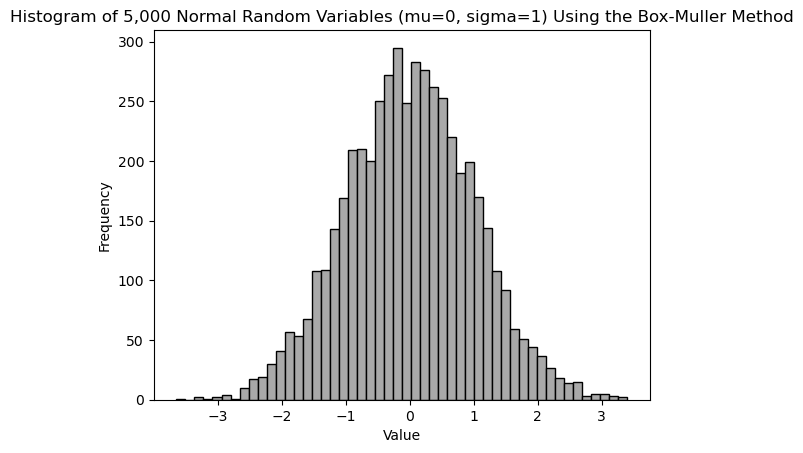

In [33]:
plotNormalBM(5000)

<hr>

## **Q1)d.**
Generate 5,000 Normally distributed random numbers with mean 0 and variance 1, by using the **Polar-Marsaglia method**.
<hr>

In [4]:
def MarsagliaPolarN(N, mu = 0, sigma = 1, seed = Rseed()):
    if not isinstance(N, int) or (N <= 0):
        raise ValueError("N must be a positive integer")
    if not isinstance(mu, (int, float)) or not isinstance(sigma, (int, float)) or not isinstance(seed, (int, float)):
        raise ValueError("Parameters must be Numeric")
    sigma = abs(sigma)
    size = (N+1)//2
    Normals = []
    for i in range(size):
        while(True):
            U1, U2 = Uniform_gen_BM(2, Rseed(Rseed()))
            V1, V2 = (2*U1 - 1), (2*U2 - 1)
            W = V1**2 + V2**2
            if W <= 1:
                break
        Z1, Z2 = (V1* np.sqrt((-2*np.log(W))/W)), (V2* np.sqrt((-2*np.log(W))/W)) 
        N1, N2 = (mu + (sigma*Z1)), (mu + (sigma*Z2))
        Normals.extend([N1, N2])
    if not (N%2 == 0):
        Normals.pop()
    return Normals

def plotNormalMP(N, mu=0, sigma=1, seed=Rseed()):
    """
    Generate N normal random variables using the Marsaglia's Polar method
    and plot their histogram.

    Parameters:
    - N (int): Number of normal random variables to generate.
    - mu (float, optional): Mean of the normal distribution (default is 0).
    - sigma (float, optional): Standard deviation of the normal distribution (default is 1).
    - seed (float, optional): Seed for random number generation (default is Rseed()).

    Returns:
    - None
    """
    Normals = MarsagliaPolarN(N, mu, sigma, seed)
    plt.hist(Normals, bins=50, color='steelblue', edgecolor='black')
    plt.grid(False)
    plt.title(f"Histogram of {N:,} Normal Random Variables (mu={mu}, sigma={sigma}) Using the Polar-Marsaglia Method")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()
    
    
    

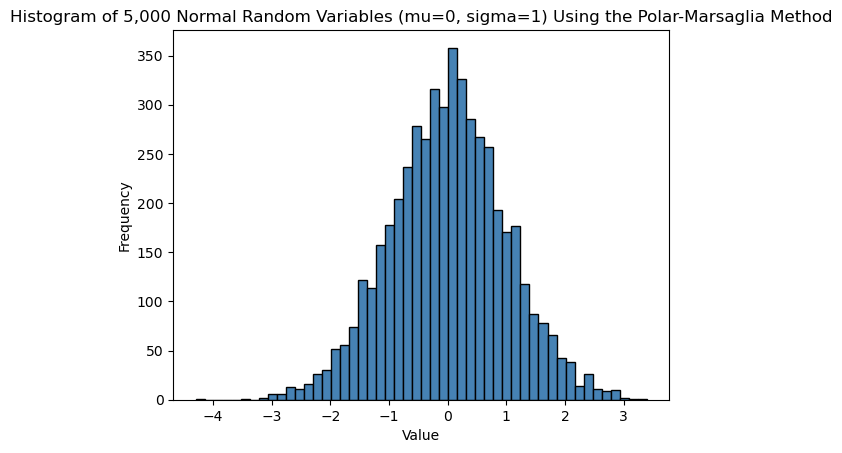

In [29]:
plotNormalMP(5000)

## **Q1)e.**
Now compare the efficiencies of the two above-algorithms, by comparing the execution times to generate 5,000 normally distributed random numbers by the two methods. **Which one is more efficient?** If you do not see a clear difference, you need to increase the number of generated realizations of random variables to 10,000, 20,000, etc.


In [40]:
def TimeCompare(N = [5000, 10_000, 20_000]):

    for i in N:
        start = time.time()
        BoxMullerN(i)
        end = time.time()
        time1 = end - start
        start = time.time()
        MarsagliaPolarN(i)
        end = time.time()
        time2 = end - start
        print(f'For size = {i:,}')
        print(f"""Time Box Muller in seconds: {time1:,0.2f};
Time Polar Marsaglia in seconds: {time2:,0.2f}
Ratio BM by PM: {time1/time2:0.3f}""")
        print()

In [43]:
TimeCompare([10_000, 20_000, 40_000, 100_000, 500_000, 1000_000])

For size = 10,000
Time Box Muller in seconds: 0.14649081230163574;
Time Polar Marsaglia in seconds: 0.13928675651550293
Ratio BM by PM: 1.052

For size = 20,000
Time Box Muller in seconds: 0.286266565322876;
Time Polar Marsaglia in seconds: 0.30109071731567383
Ratio BM by PM: 0.951

For size = 40,000
Time Box Muller in seconds: 0.5869467258453369;
Time Polar Marsaglia in seconds: 0.6044578552246094
Ratio BM by PM: 0.971

For size = 100,000
Time Box Muller in seconds: 1.4737584590911865;
Time Polar Marsaglia in seconds: 1.5699481964111328
Ratio BM by PM: 0.939

For size = 500,000
Time Box Muller in seconds: 7.153759241104126;
Time Polar Marsaglia in seconds: 7.752925157546997
Ratio BM by PM: 0.923

For size = 1,000,000
Time Box Muller in seconds: 14.324427843093872;
Time Polar Marsaglia in seconds: 14.331984758377075
Ratio BM by PM: 0.999



- Polar-Marsaglia usually outperforms Box-Muller in computation time,
  because it avoids expensive $\sin$ and $\cos$ calculations.
- But in our case, its not so visible, because we are generating multiple variables V1, V2, W and then checking inside a loop. if that can be optimised
  Polar-Marsaglia will perform better.

In [5]:
def MarsagliaPolarN2(N, mu=0, sigma=1, seed=Rseed()):
    """
    Generate N normal random variables using Marsaglia's Polar Method.

    Parameters:
    - N (int): Number of normal random variables to generate.
    - mu (float): Mean of the normal distribution (default 0).
    - sigma (float): Standard deviation of the normal distribution (default 1).
    - seed (float): Seed for random number generation (default Rseed()).

    Returns:
    - List of N normal random variables.
    """
    if not isinstance(N, int) or N <= 0:
        raise ValueError("N must be a positive integer")
    if not isinstance(mu, (int, float)) or not isinstance(sigma, (int, float)) or not isinstance(seed, (int, float)):
        raise ValueError("Parameters must be numeric")

    sigma = abs(sigma)
    size = (N + 1) // 2 
    Normals = []

    for _ in range(size):
        accept = False
        while not accept:
            U1, U2 = Uniform_gen_BM(2, Rseed(Rseed()))
            V1 = 2 * U1 - 1
            V2 = 2 * U2 - 1
            W = V1 * V1 + V2 * V2
            if 0 < W <= 1:
                factor = np.sqrt(-2 * np.log(W) / W)
                Z1 = V1 * factor
                Z2 = V2 * factor
                N1 = mu + sigma * Z1
                N2 = mu + sigma * Z2
                Normals.append(N1)
                Normals.append(N2)
                accept = True

    if N % 2 != 0:
        Normals.pop()

    return Normals
    
def TimeCompare2(N = [5000, 10_000, 20_000]):

    for i in N:
        start = time.time()
        BoxMullerN(i)
        end = time.time()
        time1 = end - start
        start = time.time()
        MarsagliaPolarN2(i)
        end = time.time()
        time2 = end - start
        print(f'For size = {i:,}')
        print(f"""Time Box Muller in seconds: {time1:,0.2f};
Time Polar Marsaglia in seconds: {time2:,0.2f}
Ratio BM by PM: {time1/time2:0.3f}""")
        print()

In [47]:
TimeCompare2([10_000, 20_000, 40_000, 100_000, 500_000, 1000_000])

For size = 10,000
Time Box Muller in seconds: 0.1103050708770752;
Time Polar Marsaglia in seconds: 0.11093568801879883
Ratio BM by PM: 0.994

For size = 20,000
Time Box Muller in seconds: 0.2690720558166504;
Time Polar Marsaglia in seconds: 0.2699270248413086
Ratio BM by PM: 0.997

For size = 40,000
Time Box Muller in seconds: 0.5861375331878662;
Time Polar Marsaglia in seconds: 0.5393826961517334
Ratio BM by PM: 1.087

For size = 100,000
Time Box Muller in seconds: 1.3770337104797363;
Time Polar Marsaglia in seconds: 1.2714588642120361
Ratio BM by PM: 1.083

For size = 500,000
Time Box Muller in seconds: 6.824722051620483;
Time Polar Marsaglia in seconds: 6.364786386489868
Ratio BM by PM: 1.072

For size = 1,000,000
Time Box Muller in seconds: 14.003218650817871;
Time Polar Marsaglia in seconds: 13.074296712875366
Ratio BM by PM: 1.071



After optimization, the **Polar-Marsaglia method** performs better than the **Box-Muller method** for large values of $N$, even though the Polar-Marsaglia method occasionally rejects samples when $W > 1$. The computational savings from avoiding expensive trigonometric functions (such as $\sin$ and $\cos$) outweigh the cost of resampling, making Polar-Marsaglia more efficient overall for generating large numbers of normal random variables.


<hr>

# Lecture 2
<hr>

## **Q2)a.**

$$
\text{(a) Estimate the following expected values by simulation:} \quad
A(t) = \mathbb{E}\left( W_t^2 + \sin(W_t) \right) \quad \text{and} \quad
B(t) = \mathbb{E}\left( e^{\frac{t}{2}} \cos(W_t) \right) \quad \text{for } t = 1, 3, 5.
$$

$$
\text{Here, } W_t \text{ is a Standard Wiener Process.}
$$


In [37]:
def A(t, N):
    Z = np.random.normal(loc=0, scale=1, size=N)
    Expression = np.square(np.sqrt(t)*Z) + np.sin((np.sqrt(t)*Z))
    return np.mean(Expression)

def B(t, N):
    Z = np.random.normal(loc=0, scale=1, size=N)
    Expression = np.exp(t/2) * np.cos((np.sqrt(t)*Z))
    return np.mean(Expression)

N = 1_000_000
for t in [1, 3, 5]:
    print(f'Expected value of A(t): {A(t, N):0.3f} & Expected Value of B(t): {B(t, N):0.3f}, at t = {t}')

Expected value of A(t): 1.000 & Expected Value of B(t): 1.000, at t = 1
Expected value of A(t): 2.995 & Expected Value of B(t): 0.997, at t = 3
Expected value of A(t): 4.996 & Expected Value of B(t): 1.016, at t = 5


<hr>

## **Q2)b.**
$$
\text{How are the values of } B(t) \text{ (for the cases } t = 1, 3, 5 \text{) related?}
$$

<hr>
<h2><b>Answer</b></h2>

$$
\text{We first express } \cos(W_t) \text{ in exponential form:}
$$

$$
\cos(W_t) = \frac{e^{iW_t} + e^{-iW_t}}{2}
$$

$$
\text{Taking expectation on both sides:}
$$

$$
\mathbb{E}\left( \cos(W_t) \right) = \frac{1}{2} \left( \mathbb{E}\left( e^{iW_t} \right) + \mathbb{E}\left( e^{-iW_t} \right) \right)
$$

$$
\text{Now, using the Moment Generating Function (MGF) formula:}
$$

$$
\mathbb{E}\left( e^{aX} \right) = e^{a\mu + \frac{1}{2}a^2\sigma^2}
$$

$$
\text{where } X \sim \mathcal{N}(\mu, \sigma^2).
$$

$$
\text{Since } W_t \sim \mathcal{N}(0,t), \text{ we have:}
$$

$$
\mathbb{E}\left( e^{iW_t} \right) = e^{0 + \frac{1}{2}(i)^2 t} = e^{-t/2}
$$

$$
\mathbb{E}\left( e^{-iW_t} \right) = e^{0 + \frac{1}{2}(-i)^2 t} = e^{-t/2}
$$

$$
\text{Thus,}
$$

$$
\mathbb{E}\left( \cos(W_t) \right) = \frac{1}{2} \left( e^{-t/2} + e^{-t/2} \right) = e^{-t/2}
$$

$$
\text{Now for } B(t), \text{ we have:}
$$

$$
B(t) = e^{t/2} \times \mathbb{E}\left( \cos(W_t) \right) = e^{t/2} \times e^{-t/2} = 1
$$

$$
\text{Thus, the expected value of } B(t) \text{ is } 1 \text{ for all } t.
$$


<hr>
<h2><b>Q2)c.</b></h2>
Now use a variance reduction technique (whichever you want) to compute the expected value \( B(5) \). Do you see any improvements? Comment on your findings.
<hr>

In [42]:
import numpy as np

def B(t, N):
    Z = np.random.normal(loc=0, scale=1, size=N)
    Expression = np.exp(t/2) * np.cos(np.sqrt(t)*Z)
    return np.mean(Expression)

def B_antithetic(t, N):
    Z = np.random.normal(loc=0, scale=1, size=N)
    Z_neg = -Z
    Expr_pos = np.exp(t/2) * np.cos(np.sqrt(t)*Z)
    Expr_neg = np.exp(t/2) * np.cos(np.sqrt(t)*Z_neg)
    Expression = (Expr_pos + Expr_neg) / 2
    return np.mean(Expression)

N = 10_000
M = 500
t = 5

results_B = []
results_B_antithetic = []

for _ in range(M):
    results_B.append(B(t, N))
    results_B_antithetic.append(B_antithetic(t, N))

results_B = np.array(results_B)
results_B_antithetic = np.array(results_B_antithetic)

variance_B = np.var(results_B, ddof=1)
variance_B_antithetic = np.var(results_B_antithetic, ddof=1)

print(f"Variance WITHOUT Antithetic: {variance_B:.6e}")
print(f"Variance WITH Antithetic:    {variance_B_antithetic:.6e}")

reduction = 100 * (1 - variance_B_antithetic / variance_B)
print(f"Variance Reduction: {reduction:.2f}%")


Variance WITHOUT Antithetic: 7.718793e-03
Variance WITH Antithetic:    6.721598e-03
Variance Reduction: 12.92%


In [43]:
print(f'Value of B(5) using MonteCarlo: {np.mean(results_B)}')
print(f'Value of B(5) using MonteCarlo and Antithetic Variances: {np.mean(results_B_antithetic)}')

Value of B(5) using MonteCarlo: 0.9996208579575634
Value of B(5) using MonteCarlo and Antithetic Variances: 1.0029327816619622


**Comment on Results:**

Using Antithetic Variates to compute \( B(5) \) resulted in a variance reduction of approximately **12.92%** compared to the standard Monte Carlo simulation.

Specifically:
- Variance without Antithetic: \( 7.718793 \times 10^{-3} \)
- Variance with Antithetic: \( 6.721598 \times 10^{-3} \)

This demonstrates that Antithetic Variates effectively reduced the variability of the estimator. Although the reduction is moderate, it is meaningful because it improves the stability and reliability of the Monte Carlo estimates without increasing the number of simulations. 

Thus, applying Antithetic Variates in this problem provided a clear improvement in estimator quality.


<hr>
<h2><b>Q3)a.</b></h2>

Let $S_t$ be a Geometric Brownian Motion process: 

$$
S_t = S_0 e^{\sigma W_t + \left( r - \frac{\sigma^2}{2} \right) t},
$$

where $r = 0.055$, $\sigma = 0.2$, $S_0 = 100$, and $W_t$ is a Standard Brownian Motion process (Standard Wiener process).
<hr>
(a) Estimate the price $c$ of a European Call option on the stock with $T=5$, $X=100$ <u><i>by using Monte Carlo simulation</i></u>.


In [44]:
def european_call_mc(S0, X, r, sigma, T, N):
    """
    Estimate the price of a European Call Option using Monte Carlo simulation.

    Parameters:
    S0    : initial stock price
    X     : strike price
    r     : risk-free rate
    sigma : volatility
    T     : time to maturity
    N     : number of simulations

    Returns:
    Estimated Call Option Price
    """
    Z = np.random.normal(0, 1, N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - X, 0)
    return np.exp(-r * T) * np.mean(payoff)

In [50]:
price_ec_mc = european_call_mc(100, 100, 0.055, 0.2, 5, 1_000_000)
print(f'Price of the European Call Option using Monte Carlo Simulation: {price_ec_mc}')

Price of the European Call Option using Monte Carlo Simulation: 30.41137210439242


<hr>
<h2><b>Q3)b.</b></h2>
Compute the exact value of the option $c$ <u><i>using the Black-Scholes formula.</i></u>
<hr>

In [46]:
from scipy.stats import norm

def black_scholes_call(S0, X, r, sigma, T):
    """
    Compute the exact Black-Scholes price of a European Call option.

    Parameters:
    S0    : initial stock price
    X     : strike price
    r     : risk-free interest rate
    sigma : volatility
    T     : time to maturity

    Returns:
    Exact Call Option Price
    """
    d1 = (np.log(S0 / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [51]:
price_ec_bs = black_scholes_call(100, 100, 0.055, 0.2, 5)
print(f'Price of the European Call Option using Black Scholes Formula: {price_ec_bs}')

Price of the European Call Option using Black Scholes Formula: 30.37265983910624


<hr>
<h2><b>Q3)c.</b></h2>
Use variance reduction techniques (whichever one(s) you want) to estimate the price in part (a) again using the same number of simulations. Did the accuracy improve? Compare your findings and comment.
<hr>

In [56]:
def european_call_mc_antithetic(S0, X, r, sigma, T, N):
    """
    Estimate the price of a European Call Option using Monte Carlo simulation with Antithetic Variates.

    Parameters:
    S0    : initial stock price
    X     : strike price
    r     : risk-free rate
    sigma : volatility
    T     : time to maturity
    N     : number of simulations

    Returns:
    Estimated Call Option Price
    """
    Z = np.random.normal(0, 1, N//2)
    Z_neg = -Z
    ST_pos = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST_neg = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_neg)
    payoff_pos = np.maximum(ST_pos - X, 0)
    payoff_neg = np.maximum(ST_neg - X, 0)
    payoff = (payoff_pos + payoff_neg) / 2
    return np.exp(-r * T) * np.mean(payoff)

In [57]:
price_ec_mc_antithetic = european_call_mc_antithetic(100, 100, 0.055, 0.2, 5, 1_000_000)
print(f'Price of the European Call Option using Monte Carlo Simulation: {price_ec_mc_antithetic}')

Price of the European Call Option using Monte Carlo Simulation: 30.389455329127664


In [59]:
def compare_mc_errors(S0, X, r, sigma, T, N, M):
    """
    Compare the accuracy of standard Monte Carlo and Antithetic Variates Monte Carlo
    against the exact Black-Scholes value.

    Parameters:
    S0    : initial stock price
    X     : strike price
    r     : risk-free rate
    sigma : volatility
    T     : time to maturity
    N     : number of simulations per run
    M     : number of independent replications

    Returns:
    Tuple of (standard Monte Carlo MSE, antithetic variates MSE)
    """
    bs_value = black_scholes_call(S0, X, r, sigma, T)
    errors_mc = []
    errors_mc_antithetic = []

    for _ in range(M):
        mc_price = european_call_mc(S0, X, r, sigma, T, N)
        mc_antithetic_price = european_call_mc_antithetic(S0, X, r, sigma, T, N)
        errors_mc.append((bs_value - mc_price)**2)
        errors_mc_antithetic.append((bs_value - mc_antithetic_price)**2)

    mse_mc = np.mean(errors_mc)
    mse_mc_antithetic = np.mean(errors_mc_antithetic)

    return mse_mc, mse_mc_antithetic


In [62]:
S0 = 100
X = 100
r = 0.055
sigma = 0.2
T = 5
N = 100_000
M = 500

error_mc, error_mc_antithetic = compare_mc_errors(S0, X, r, sigma, T, N, M)

In [63]:
print(f"Standard MC Mean Squared Error: {error_mc:.2e}")
print(f"Antithetic MC Mean Squared Error: {error_mc_antithetic:.2e}")
print(f"Ratio of Errors:{error_mc/error_mc_antithetic:.2f}")

Standard MC Mean Squared Error: 1.57e-02
Antithetic MC Mean Squared Error: 7.88e-03
Ratio of Errors:1.99


<h3> Comment on Results</h3>

With $N = 100,\!000$ simulations, the standard Monte Carlo method had a mean squared error of $1.57 \times 10^{-2}$, while the Antithetic Variates method had a lower error of $7.88 \times 10^{-3}$.  
The ratio of errors was approximately $2$, showing that Antithetic Variates nearly halved the error and improved the accuracy significantly.


<hr>
<h2><b>Q4)a.</b></h2>
For each integer number $n$ from 1 to 10, use 1,000 simulations of $S_n$ to estimate $\mathbb{E}(S_n)$, where

$$
S_t = S_0 e^{\sigma W_t + \left( r - \frac{\sigma^2}{2} \right) t},
$$

where $r = 0.055$, $\sigma = 0.20$, $S_0 = 88$. Plot all of the above $\mathbb{E}(S_n)$ for $n$ ranging from 1 to 10 in one graph.

<hr>

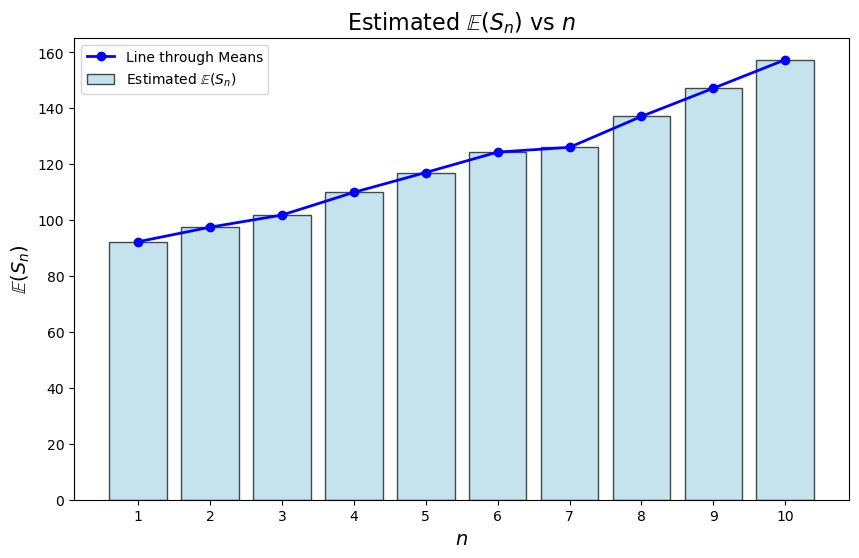

In [67]:
def simulate_mean_Sn(S0, r, sigma, n_simulations):
    """
    Simulate E(Sn) for n = 1 to 10.
    """
    means = []
    for n in range(1, 11):
        Z = np.random.normal(0, 1, n_simulations)
        ST = S0 * np.exp((r - 0.5 * sigma**2) * n + sigma * np.sqrt(n) * Z)
        means.append(np.mean(ST))
    return means

S0 = 88
r = 0.055
sigma = 0.20
n_simulations = 1000

mean_Sn = simulate_mean_Sn(S0, r, sigma, n_simulations)

plt.figure(figsize=(10,6))
n_values = np.arange(1, 11)
plt.bar(n_values, mean_Sn, color='lightblue', edgecolor='black', alpha=0.7, label='Estimated $\mathbb{E}(S_n)$')
plt.plot(n_values, mean_Sn, color='blue', marker='o', linewidth=2, label='Line through Means')
plt.title(r'Estimated $\mathbb{E}(S_n)$ vs $n$', fontsize=16)
plt.xlabel(r'$n$', fontsize=14)
plt.ylabel(r'$\mathbb{E}(S_n)$', fontsize=14)
plt.xticks(n_values)
plt.legend()
plt.show()


<hr>
<h2><b>Q4)b.</b></h2>
Simulate 3 paths of $S_t$ for $0 \leq t \leq 10$ by dividing the interval [0,10] into 1,000 equal parts.

<hr>

In [68]:
def simulate_paths(S0, r, sigma, T, steps, n_paths):
    """
    Simulate multiple paths of S_t.
    """
    dt = T / steps
    t = np.linspace(0, T, steps + 1)
    paths = np.zeros((n_paths, steps + 1))
    paths[:, 0] = S0
    for i in range(1, steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return t, paths


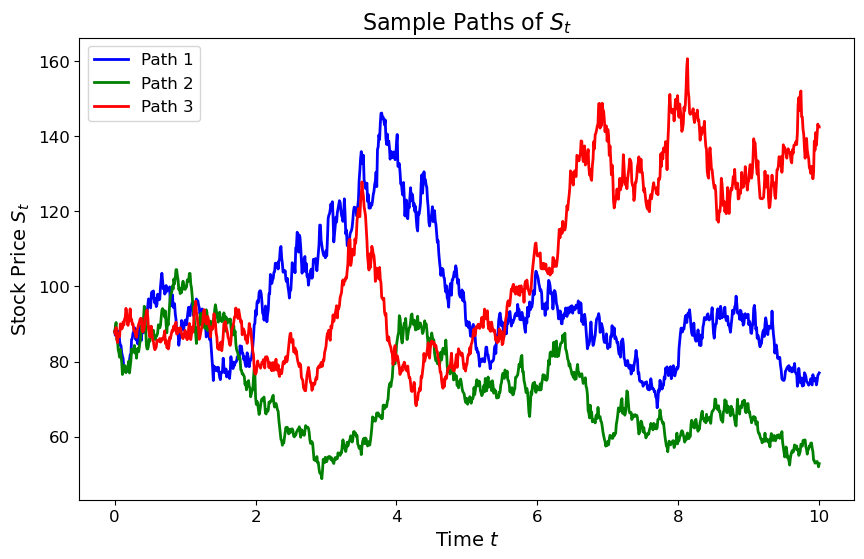

In [69]:
T = 10
steps = 1000
n_paths = 3

t, paths = simulate_paths(S0, r, sigma, T, steps, n_paths)
plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red']

for i in range(n_paths):
    plt.plot(t, paths[i], label=f'Path {i+1}', color=colors[i], linewidth=2)

plt.title(r'Sample Paths of $S_t$', fontsize=16)
plt.xlabel(r'Time $t$', fontsize=14)
plt.ylabel(r'Stock Price $S_t$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.show()


<hr>
<h2><b>Q4)c.</b></h2>
Plot your data from parts (a) and (b) in one graph.
<hr>

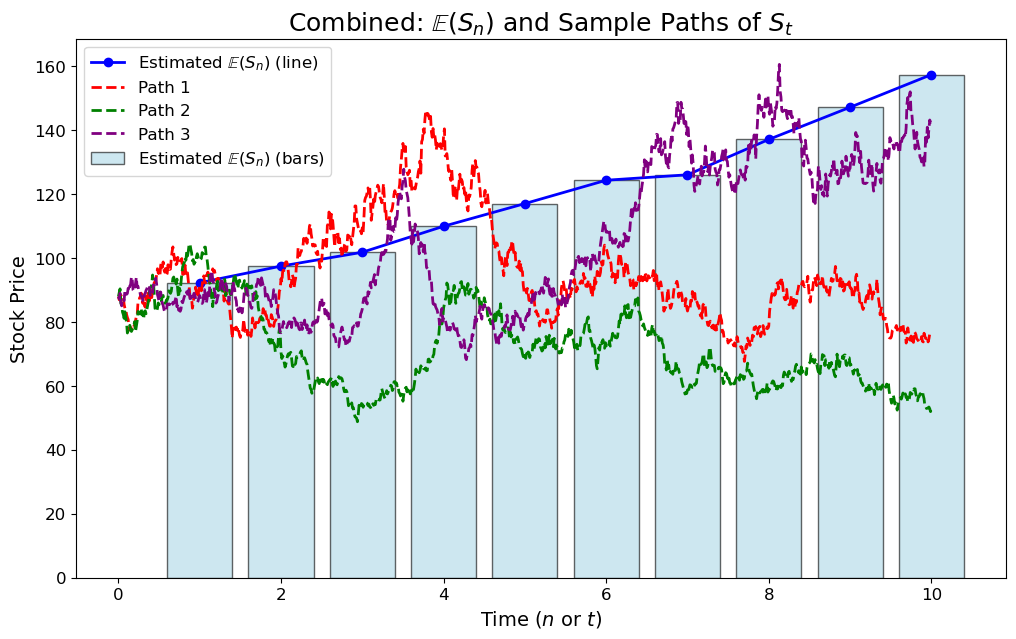

In [73]:
plt.figure(figsize=(12,7))
n_values = np.arange(1, 11)

plt.bar(n_values, mean_Sn, color='lightblue', edgecolor='black', alpha=0.6, label=r'Estimated $\mathbb{E}(S_n)$ (bars)')
plt.plot(n_values, mean_Sn, color='blue', marker='o', linewidth=2, label=r'Estimated $\mathbb{E}(S_n)$ (line)')

colors = ['red', 'green', 'purple']
for i in range(n_paths):
    plt.plot(t, paths[i], color=colors[i], linewidth=2, linestyle='--', label=f'Path {i+1}')

plt.title(r'Combined: $\mathbb{E}(S_n)$ and Sample Paths of $S_t$', fontsize=18)
plt.xlabel(r'Time ($n$ or $t$)', fontsize=14)
plt.ylabel(r'Stock Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.show()


<hr>
<h2><b>Q4)d.</b></h2>
What would happen to the $\mathbb{E}(S_n)$ graph and the 3 paths of $S_t$ if you increased $\sigma$ from 20% to 30%?
<hr>

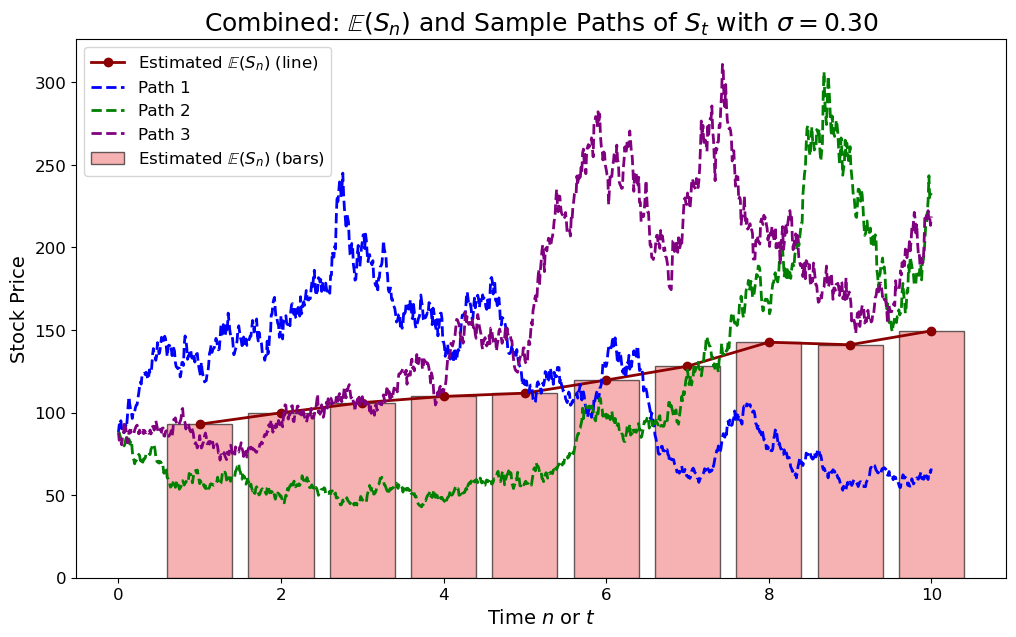

In [74]:
# New sigma
sigma_new = 0.30

# Re-simulate mean E(Sn)
mean_Sn_new = simulate_mean_Sn(S0, r, sigma_new, n_simulations)

# Re-simulate paths
t_new, paths_new = simulate_paths(S0, r, sigma_new, T, steps, n_paths)

# Combined Plot
plt.figure(figsize=(12,7))
n_values = np.arange(1, 11)

plt.bar(n_values, mean_Sn_new, color='lightcoral', edgecolor='black', alpha=0.6, label=r'Estimated $\mathbb{E}(S_n)$ (bars)')
plt.plot(n_values, mean_Sn_new, color='darkred', marker='o', linewidth=2, label=r'Estimated $\mathbb{E}(S_n)$ (line)')

colors = ['blue', 'green', 'purple']
for i in range(n_paths):
    plt.plot(t_new, paths_new[i], color=colors[i], linewidth=2, linestyle='--', label=f'Path {i+1}')

plt.title(r'Combined: $\mathbb{E}(S_n)$ and Sample Paths of $S_t$ with $\sigma=0.30$', fontsize=18)
plt.xlabel(r'Time $n$ or $t$', fontsize=14)
plt.ylabel(r'Stock Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.show()


<h3>Comment on Changing $\sigma$ from 20% to 30%</h3>

When $\sigma$ was increased from 20% to 30%, the following observations were made:

- The expected value curve $\mathbb{E}(S_n)$ remained largely unchanged. This is because $\mathbb{E}(S_n)$ depends mainly on the drift term and not directly on volatility.
- However, the 3 sample paths of $S_t$ became much more volatile, showing larger fluctuations and greater dispersion.
- Higher $\sigma$ led to more extreme movements both upward and downward, making the paths more unpredictable and spread out.

Thus, while the average expected behavior is stable, individual paths become riskier and more erratic with increased volatility.


<hr>
<h2><b>Q5)a.</b></h2>

Write a code to compute prices of European Call options via Monte Carlo simulation of paths of the stock price process. Use <b>Euler’s</b> discretization scheme to discretize the SDE for the stock price process.  
The code should be generic: for any input of the 5 model parameters - $S_0, T, X, r, \sigma$ — the output is the corresponding price of the European call option and the standard error of the estimate.

<hr>


In [9]:
def european_call_mc_euler(S0, T, X, r, sigma, steps=1000, n_simulations=1_000_000):
    """
    Estimate the price of a European Call option using Monte Carlo simulation
    with Euler discretization of the SDE.

    Parameters:
    S0            : initial stock price
    T             : time to maturity
    X             : strike price
    r             : risk-free interest rate
    sigma         : volatility
    steps         : number of time steps per unit time
    n_simulations : number of simulated paths

    Returns:
    Tuple of (option price estimate, standard error)
    """
    dt = 1 / steps
    total_steps = int(steps * T)
    S = np.full((n_simulations,), S0, dtype=float)
    for _ in range(total_steps):
        Z = np.random.normal(0, 1, n_simulations)
        S += r * S * dt + sigma * S * np.sqrt(dt) * Z
    payoffs = np.maximum(S - X, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    option_price = np.mean(discounted_payoffs)
    standard_error = np.std(discounted_payoffs, ddof=1) / np.sqrt(n_simulations)
    return option_price, standard_error

In [10]:
print(european_call_mc_euler(84, 3, 100, 0.042, 0.2))

(9.863937539542599, 0.019615003804359404)


<hr>
<h2><b>Q5)b.</b></h2>

Write a code to compute prices of European Call options via Monte Carlo simulation of paths of the stock price process. Use <b>Milshtein’s</b> discretization scheme to discretize the SDE for the stock price process.  
The code should be generic: for any input of the 5 model parameters - $S_0, T, X, r, \sigma$ — the output is the corresponding price of the European call option and the standard error of the estimate.

<hr>

In [11]:
def european_call_mc_milstein(S0, T, X, r, sigma, steps=1000, n_simulations=1_000_000):
    """
    Estimate the price of a European Call option using Monte Carlo simulation
    with Milstein discretization of the SDE.

    Parameters:
    S0            : initial stock price
    T             : time to maturity
    X             : strike price
    r             : risk-free interest rate
    sigma         : volatility
    steps         : number of time steps per unit time
    n_simulations : number of simulated paths

    Returns:
    Tuple of (option price estimate, standard error)
    """
    dt = 1 / steps
    total_steps = int(steps * T)
    S = np.full((n_simulations,), S0, dtype=float)
    for _ in range(total_steps):
        Z = np.random.normal(0, 1, n_simulations)
        S += r * S * dt + sigma * S * np.sqrt(dt) * Z + 0.5 * sigma**2 * S * (Z**2 - 1) * dt
    payoffs = np.maximum(S - X, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    option_price = np.mean(discounted_payoffs)
    standard_error = np.std(discounted_payoffs, ddof=1) / np.sqrt(n_simulations)
    return option_price, standard_error


In [12]:
print(european_call_mc_milstein(84, 3, 100, 0.042, 0.2))

(9.865300290112044, 0.019627032972307102)


<hr>
<h2><b>Q5)c.</b></h2>

Write code to compute the prices of European Call options by using the Black-Scholes formula. Use the approximation of $N(\cdot)$ described in Chapter 3.  
The code should be generic: for any input values of the 5 parameters - $S_0, T, X, r, \sigma$ — the output is the corresponding price of the European call option.

<hr>


In [13]:
def black_scholes_call_Napprox(S0, T, X, r, sigma):
    """
    Compute the price of a European Call option using the Black-Scholes formula
    with numerical approximation of N(x).

    Parameters:
    S0    : initial stock price
    T     : time to maturity
    X     : strike price
    r     : risk-free interest rate
    sigma : volatility

    Returns:
    European call option price
    """
    def N(x):
        d1 = 0.0498673470
        d2 = 0.0211410061
        d3 = 0.0032776263
        d4 = 0.0000380036
        d5 = 0.0000488906
        d6 = 0.0000053830
        if x >= 0:
            poly = 1 + d1*x + d2*x**2 + d3*x**3 + d4*x**4 + d5*x**5 + d6*x**6
            return 1 - 0.5 * poly**(-16)
        else:
            return 1 - N(-x)

    d1 = (np.log(S0 / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * N(d1) - X * np.exp(-r * T) * N(d2)
    return call_price


In [14]:
print(black_scholes_call_Napprox(84, 3, 100, 0.042, 0.2))

9.870155085671321


<hr>
<h2><b>Q5)d.</b></h2>

Use the results of (a) to (c) to compare the two schemes of parts (a) and (b), by computing the European Call option prices for the following parameter values: $X = 100$, $\sigma = 0.25$, $r = 0.055$, $T = 0.5$, and $S_0$ ranges in $[95, 104]$ with a step size of 1.

<hr>



In [23]:
S0_values = np.arange(95, 105)
X = 100
sigma = 0.25
r = 0.055
T = 0.5
steps = 1000
n_simulations = 10_000
n_runs = 50


for S0 in S0_values:
    bs_price = black_scholes_call_Napprox(S0, T, X, r, sigma)
    mse_euler = 0
    mse_milstein = 0

    for _ in range(n_runs):
        price_euler, _ = european_call_mc_euler(S0, T, X, r, sigma, steps, n_simulations)
        price_milstein, _ = european_call_mc_milstein(S0, T, X, r, sigma, steps, n_simulations)
        mse_euler += (price_euler - bs_price)**2
        mse_milstein += (price_milstein - bs_price)**2

    mse_euler /= n_runs
    mse_milstein /= n_runs

    print(f"For initial stock price S₀ = {S0}:")
    print(f"    Mean Squared Error (Euler Scheme):    {mse_euler:.4e}")
    print(f"    Mean Squared Error (Milstein Scheme): {mse_milstein:.4e}")
    print("-" * 70)


For initial stock price S₀ = 95:
    Mean Squared Error (Euler Scheme):    1.0289e-02
    Mean Squared Error (Milstein Scheme): 1.0760e-02
----------------------------------------------------------------------
For initial stock price S₀ = 96:
    Mean Squared Error (Euler Scheme):    1.0761e-02
    Mean Squared Error (Milstein Scheme): 1.1902e-02
----------------------------------------------------------------------
For initial stock price S₀ = 97:
    Mean Squared Error (Euler Scheme):    1.2784e-02
    Mean Squared Error (Milstein Scheme): 9.8074e-03
----------------------------------------------------------------------
For initial stock price S₀ = 98:
    Mean Squared Error (Euler Scheme):    1.3646e-02
    Mean Squared Error (Milstein Scheme): 1.5768e-02
----------------------------------------------------------------------
For initial stock price S₀ = 99:
    Mean Squared Error (Euler Scheme):    1.2320e-02
    Mean Squared Error (Milstein Scheme): 1.7483e-02
---------------------

<hr>
<h2><b>Q5)e.</b></h2>

Estimate the European call option’s greeks – delta $(\Delta)$, gamma $(\Gamma)$, theta $(\theta)$, and vega $(v)$ – and graph them as functions of the initial stock price $S_0$.  
Use $X = 100$, $\sigma = 0.25$, $r = 0.055$ and $T = 0.5$ in your estimations. Use the range $[95, 105]$ for $S_0$, with a step size of 1. You will have 4 different graphs for each of the 4 greeks.  
In all cases, $dt$ (time-step) should be user-defined. Use $dt = 0.05$ as a default value.

<hr>


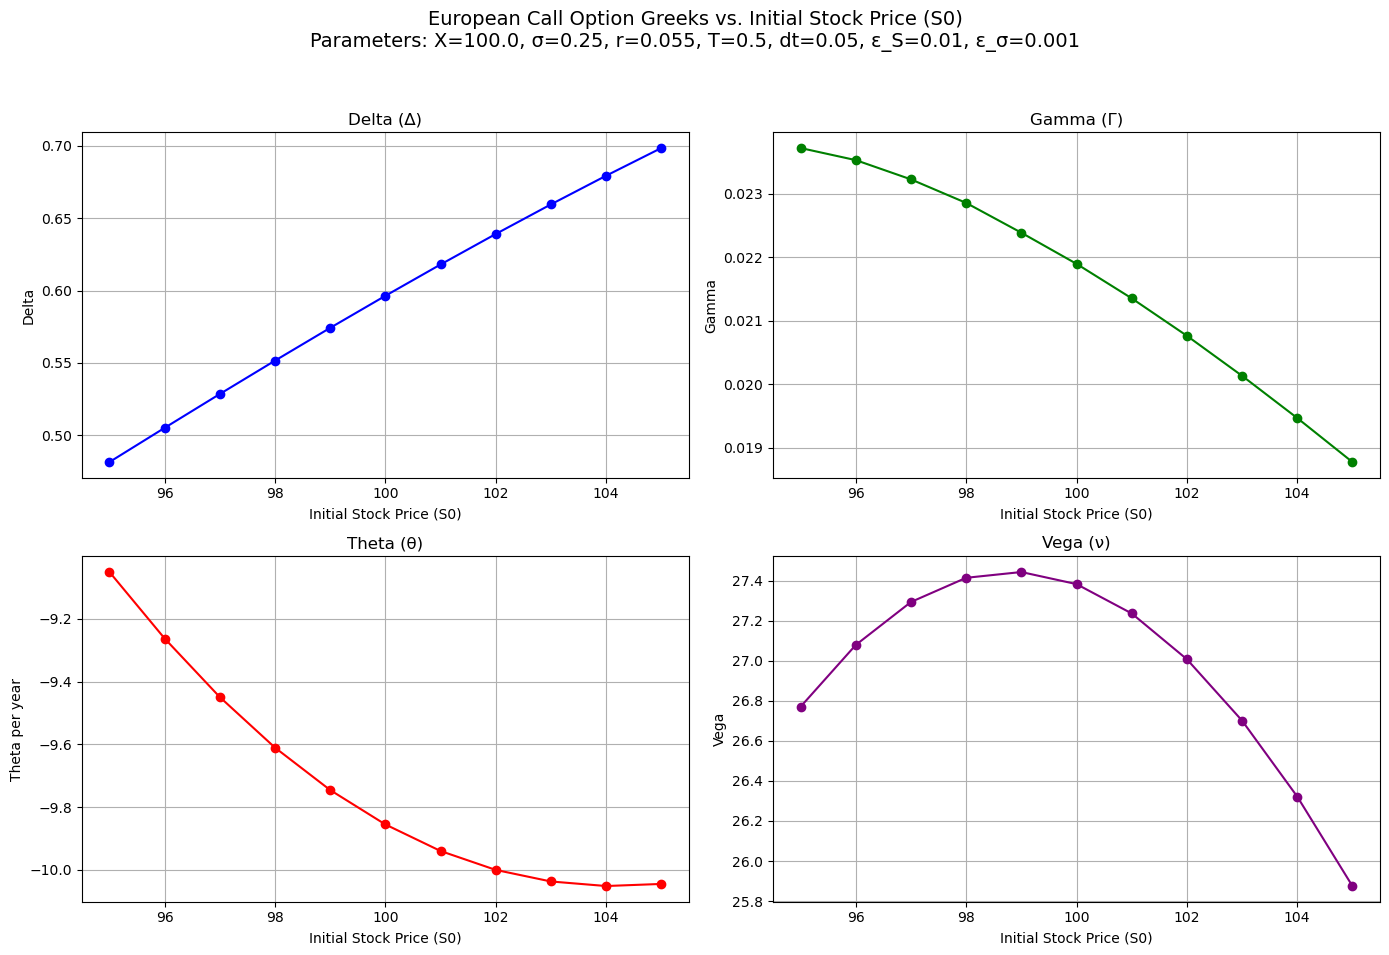


Calculations complete using approximated N(x). Displaying combined plot.

Sample Greek Values:
S0       Delta      Gamma      Theta        Vega      
--------------------------------------------------
95.00    0.4816     0.0237     -9.0503      26.7703   
97.00    0.5286     0.0232     -9.4493      27.2930   
99.00    0.5742     0.0224     -9.7457      27.4426   
101.00   0.6180     0.0214     -9.9401      27.2360   
103.00   0.6595     0.0201     -10.0372     26.7009   
105.00   0.6984     0.0188     -10.0451     25.8751   


In [22]:
import numpy as np
import matplotlib.pyplot as plt
# Note: scipy.stats.norm is no longer needed as N(x) is approximated internally

# --- Black-Scholes Call Option Pricing Function with N(x) Approximation ---

# --- Parameters ---
X = 100.0      
sigma = 0.25   
r = 0.055      
T = 0.5        
dt = 0.05      

# Define range for S0
S0_min = 95.0
S0_max = 105.0
S0_step = 1.0
S0_values = np.arange(S0_min, S0_max + S0_step, S0_step)

# --- Finite Difference Perturbations ---
epsilon_S = 0.01 
epsilon_sigma = 0.001 

# --- Lists to store Greek values ---
deltas = []
gammas = []
thetas = []
vegas = []

# --- Calculate Greeks for each S0 ---
for S0 in S0_values:
    # Central difference for Delta
    price_up_S = black_scholes_call_Napprox(S0 + epsilon_S, T, X, r, sigma)
    price_down_S = black_scholes_call_Napprox(S0 - epsilon_S, T, X, r, sigma)
    delta = (price_up_S - price_down_S) / (2 * epsilon_S)
    deltas.append(delta)

    # Central difference for Gamma
    price_current = black_scholes_call_Napprox(S0, T, X, r, sigma)
    gamma = (price_up_S - 2 * price_current + price_down_S) / (epsilon_S**2)
    gammas.append(gamma)

    # Backward difference for Theta
    if T > dt:
        price_prev_T = black_scholes_call_Napprox(S0, T - dt, X, r, sigma)
        theta = (price_prev_T - price_current) / dt 
    else:
         price_at_expiry = black_scholes_call_Napprox(S0, 0, X, r, sigma) 
         if T > 1e-9: 
             theta = (price_at_expiry - price_current) / T
         else:
             theta = 0.0 
         print(f"Warning: T <= dt at S0={S0}. Using alternative Theta estimation based on remaining time T.")

    thetas.append(theta)

    # Central difference for Vega
    price_up_sigma = black_scholes_call_Napprox(S0, T, X, r, sigma + epsilon_sigma)
    if sigma > epsilon_sigma:
         price_down_sigma = black_scholes_call_Napprox(S0, T, X, r, sigma - epsilon_sigma)
         vega = (price_up_sigma - price_down_sigma) / (2 * epsilon_sigma)
    else:
        vega = (price_up_sigma - price_current) / epsilon_sigma
        print(f"Warning: sigma <= epsilon_sigma at S0={S0}. Using forward difference for Vega.")
        
    vegas.append(vega)

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10)) 
fig.suptitle(f'European Call Option Greeks vs. Initial Stock Price (S0)\n'
             f'Parameters: X={X}, σ={sigma}, r={r}, T={T}, dt={dt}, ε_S={epsilon_S}, ε_σ={epsilon_sigma}', 
             fontsize=14)

# Plot Delta
axs[0, 0].plot(S0_values, deltas, marker='o', linestyle='-', color='blue')
axs[0, 0].set_title('Delta (∆)')
axs[0, 0].set_xlabel('Initial Stock Price (S0)')
axs[0, 0].set_ylabel('Delta')
axs[0, 0].grid(True)

# Plot Gamma
axs[0, 1].plot(S0_values, gammas, marker='o', linestyle='-', color='green')
axs[0, 1].set_title('Gamma (Γ)')
axs[0, 1].set_xlabel('Initial Stock Price (S0)')
axs[0, 1].set_ylabel('Gamma')
axs[0, 1].grid(True)

# Plot Theta
axs[1, 0].plot(S0_values, thetas, marker='o', linestyle='-', color='red')
axs[1, 0].set_title('Theta (θ)')
axs[1, 0].set_xlabel('Initial Stock Price (S0)')
axs[1, 0].set_ylabel('Theta per year')
axs[1, 0].grid(True)

# Plot Vega
axs[1, 1].plot(S0_values, vegas, marker='o', linestyle='-', color='purple')
axs[1, 1].set_title('Vega (ν)')
axs[1, 1].set_xlabel('Initial Stock Price (S0)')
axs[1, 1].set_ylabel('Vega')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# Show plot
plt.show()

# --- Print Sample Results ---
print("\nCalculations complete using approximated N(x). Displaying combined plot.")
print("\nSample Greek Values:")
print(f"{'S0':<8} {'Delta':<10} {'Gamma':<10} {'Theta':<12} {'Vega':<10}")
print("-" * 50)
indices_to_print = np.linspace(0, len(S0_values) - 1, num=min(6, len(S0_values)), dtype=int) # Print up to 6 samples evenly spaced
for i in indices_to_print:
     print(f"{S0_values[i]:<8.2f} {deltas[i]:<10.4f} {gammas[i]:<10.4f} {thetas[i]:<12.4f} {vegas[i]:<10.4f}")

<hr>
<h2><b>Q6.</b></h2>

Consider the following 2-factor model for stock prices with stochastic volatility:

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{V_t} S_t \, dW_t^1 \\
dV_t &= \alpha (\beta - V_t) \, dt + \sigma \sqrt{V_t} \, dW_t^2
\end{aligned}
$$

where the Brownian Motion processes above are correlated:  
$$
dW_t^1 dW_t^2 = \rho \, dt
$$
where the correlation $\rho$ is a constant in $\left[-1,1\right]$.

**Task:**  
Estimate the price of a European Call option (via Monte Carlo simulation) that has a strike price of $X$ and matures in $T$ years.

Use the following default parameters of the model:

$$
\rho = -0.6, \quad r = 0.055, \quad S_0 = 100, \quad X = 100, \quad T = 1, \quad V_0 = 0.05, \quad \sigma = 0.42, \quad \alpha = 5.8, \quad \beta = 0.0625, \quad dt = 0.05, \quad N = 10,000
$$

Use the **Full Truncation**, **Partial Truncation**, and **Reflection** methods, and provide 3 price estimates by using the tree methods.
<hr>

In [24]:
import numpy as np

def monte_carlo_heston_call(
    S0: float = 100.0,
    V0: float = 0.05,
    r: float = 0.055,
    rho: float = -0.6,
    alpha: float = 5.8,
    beta: float = 0.0625,
    sigma: float = 0.42,
    T: float = 1.0,
    X: float = 100.0,
    N: int = 10000,
    dt: float = 0.05
) -> tuple[float, float, float]:
    """
    Estimates European call option price using Monte Carlo simulation
    for the Heston stochastic volatility model.

    Implements Full Truncation, Partial Truncation, and Reflection schemes
    for simulating the variance process to handle potential negative values.

    Args:
        S0 (float): Initial stock price. Default: 100.0.
        V0 (float): Initial variance (V_t). Default: 0.05.
        r (float): Risk-free interest rate. Default: 0.055.
        rho (float): Correlation between stock and variance Brownian motions.
                     Default: -0.6.
        alpha (float): Speed of variance mean reversion (kappa in some literature).
                       Default: 5.8.
        beta (float): Long-run average variance (theta in some literature).
                      Default: 0.0625.
        sigma (float): Volatility of variance ('vol-of-vol'). Default: 0.42.
        T (float): Time to maturity (in years). Default: 1.0.
        X (float): Strike price of the call option. Default: 100.0.
        N (int): Number of Monte Carlo simulation paths. Default: 10000.
        dt (float): Time step size for the simulation. Default: 0.05.

    Returns:
        tuple[float, float, float]: A tuple containing the estimated call
                                     option prices for the (1) Full Truncation,
                                     (2) Partial Truncation, and (3) Reflection
                                     schemes, respectively (C1, C2, C3).
    """

    num_steps = int(T / dt)
    if not abs(num_steps * dt - T) < 1e-9:
         print(f"Warning: T ({T}) is not an exact multiple of dt ({dt}). "
               f"Using {num_steps} steps.")

    sqrt_dt = np.sqrt(dt)

    Z1 = np.random.standard_normal((N, num_steps))
    Z2 = np.random.standard_normal((N, num_steps))
    dW1 = sqrt_dt * Z1
    dW2 = sqrt_dt * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

    S_ft = np.full(N, S0)
    V_ft = np.full(N, V0)
    S_pt = np.full(N, S0)
    V_pt = np.full(N, V0)
    S_rf = np.full(N, S0)
    V_rf = np.full(N, V0)

    for i in range(num_steps):
        V_star_ft = np.maximum(V_ft, 0)
        sqrt_V_star_ft = np.sqrt(V_star_ft)
        V_ft += alpha * (beta - V_star_ft) * dt + sigma * sqrt_V_star_ft * dW2[:, i]
        S_ft += r * S_ft * dt + sqrt_V_star_ft * S_ft * dW1[:, i]

        V_star_pt_diff = np.maximum(V_pt, 0)
        sqrt_V_star_pt_diff = np.sqrt(V_star_pt_diff)
        V_pt += alpha * (beta - V_pt) * dt + sigma * sqrt_V_star_pt_diff * dW2[:, i]
        S_pt += r * S_pt * dt + sqrt_V_star_pt_diff * S_pt * dW1[:, i]

        sqrt_V_star_rf = np.sqrt(np.abs(V_rf))
        V_rf += alpha * (beta - V_rf) * dt + sigma * sqrt_V_star_rf * dW2[:, i]
        S_rf += r * S_rf * dt + sqrt_V_star_rf * S_rf * dW1[:, i]

    payoff_ft = np.maximum(S_ft - X, 0)
    payoff_pt = np.maximum(S_pt - X, 0)
    payoff_rf = np.maximum(S_rf - X, 0)

    C1 = np.mean(payoff_ft) * np.exp(-r * T)
    C2 = np.mean(payoff_pt) * np.exp(-r * T)
    C3 = np.mean(payoff_rf) * np.exp(-r * T)

    return C1, C2, C3

print("Running Heston Monte Carlo simulation with default parameters...")
price_ft_default, price_pt_default, price_rf_default = monte_carlo_heston_call()

print(f"\n--- Results (Default Parameters) ---")
print(f"Estimated Call Price (Full Truncation):   {price_ft_default:.4f}")
print(f"Estimated Call Price (Partial Truncation): {price_pt_default:.4f}")
print(f"Estimated Call Price (Reflection):        {price_rf_default:.4f}")

Running Heston Monte Carlo simulation with default parameters...

--- Results (Default Parameters) ---
Estimated Call Price (Full Truncation):   12.7160
Estimated Call Price (Partial Truncation): 12.7168
Estimated Call Price (Reflection):        12.7165


<hr>

<h2><b>Q7.</b></h2>

The objective of this exercise is to compare a sample of Pseudo-Random numbers with a sample of Quasi-Monte Carlo numbers of <i>Uniform</i>$[0,1] \times [0,1]$:

Use 2-dimensional Halton sequences to estimate the following integral:

$$
I = \int_0^1 \int_0^1 e^{-xy} \left( \sin(6\pi x) + \cos\left(\frac{13}{2}\pi y\right) \right) dx \, dy
$$

Default parameter values:  
$N=10,000$; bases = $(2,3)$.

<br>

<b>Inputs:</b>  
b1, b2 (the bases); N

<b>Outputs:</b>  
$I$

<hr>


In [26]:
import numpy as np
from scipy.stats import qmc
import math

def f(x, y):
    term1 = np.sin(6 * np.pi * x)
    term2 = np.cbrt(np.cos(2 * np.pi * y))
    return np.exp(-x * y) * (term1 + term2)

def estimate_integral_halton(b1, b2, N):
    sampler = qmc.Halton(d=2, seed=None)
    sample = sampler.random(n=N)
    x_coords = sample[:, 0]
    y_coords = sample[:, 1]
    f_values = f(x_coords, y_coords)
    integral_estimate = np.mean(f_values)
    return integral_estimate

def estimate_integral_mc(N):
    sample = np.random.rand(N, 2)
    x_coords = sample[:, 0]
    y_coords = sample[:, 1]
    f_values = f(x_coords, y_coords)
    integral_estimate = np.mean(f_values)
    return integral_estimate

def estimate_integral_sobol(N):
    sampler = qmc.Sobol(d=2, scramble=True, seed=None)
    sample = sampler.random(n=N)
    x_coords = sample[:, 0]
    y_coords = sample[:, 1]
    f_values = f(x_coords, y_coords)
    integral_estimate = np.mean(f_values)
    return integral_estimate

N_points = 10000
base1 = 2
base2 = 3

I_halton = estimate_integral_halton(base1, base2, N_points)
I_mc = estimate_integral_mc(N_points)
I_sobol = estimate_integral_sobol(N_points)


print(f"Number of points (N): {N_points}")
print(f"\n--- Estimation Methods ---")
print(f"1. Standard Monte Carlo (Pseudo-Random): Estimated I = {I_mc}")
print(f"2. Quasi-Monte Carlo (Halton [{base1},{base2}]): Estimated I = {I_halton}")
print(f"3. Quasi-Monte Carlo (Sobol):           Estimated I = {I_sobol}")

Number of points (N): 10000

--- Estimation Methods ---
1. Standard Monte Carlo (Pseudo-Random): Estimated I = 0.016447359985410814
2. Quasi-Monte Carlo (Halton [2,3]): Estimated I = 0.026047773322338832
3. Quasi-Monte Carlo (Sobol):           Estimated I = 0.02611734100331451


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
